## 0. Import Libraries

In [38]:
from shapely.geometry import mapping
from cartopy.feature import ShapelyFeature
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.colors import LinearSegmentedColormap

import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt

import cartopy
import utils
import proplot

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. xth Percentile Analysis

In [56]:
path_general = r'/mnt/d/JupyterLab/Yuksek_Lisans/msc_thesis_data'
q=0.90 # 0.50 and 0.90

### 1.1 Open Data

In [57]:
# change these
season = 'DJF'
bias_algo = 'QDM' # EQM or QDM
# ----------------------------------------------

time_resample = 6
# path for resampling information
if time_resample != 1:
    path_resample = fr'{time_resample}hrsum'
else:
    path_resample = fr'{time_resample}hr'
    
# variable name
name_variable_cosmo = 'TOT_PREC'
name_variable_era5 = 'tp'

#### 1.1.1 Model

In [58]:
# normal kullanım aşağıdaki
dt_model = xr.open_dataset(fr'{path_general}/cosmo/yearly/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_{season}_{path_resample}_merged_198501_200512.nc',
                     #chunks={"time": -1}
                          )[name_variable_cosmo]

In [59]:
dt_model

<xarray.DataArray 'TOT_PREC' (time: 7601, rlat: 59, rlon: 137)>
[61438883 values with dtype=float64]
Coordinates:
  * rlon     (rlon) float32 -5.55 -5.44 -5.33 -5.22 -5.11 ... 9.08 9.19 9.3 9.41
  * rlat     (rlat) float32 -4.11 -4.0 -3.89 -3.78 -3.67 ... 1.94 2.05 2.16 2.27
  * time     (time) datetime64[ns] 1985-01-01 ... 2005-12-31T18:00:00
    lon      (rlat, rlon) float32 ...
    lat      (rlat, rlon) float32 ...

#### 1.1.2 ERA5

In [60]:
dt_era5 = xr.open_dataset(fr'{path_general}/era5/era5_TOT_PREC_{season}_{path_resample}_1985_2005.nc',
                     #chunks={"latitude": 10, 'longitude':10}
                         )[name_variable_era5]*1e3 # to mm

In [61]:
dt_era5

<xarray.DataArray 'tp' (time: 7601, latitude: 41, longitude: 93)>
array([[[5.75697049e-03, 2.78605148e-03, 1.48592517e-03, ...,
         2.76705250e-02, 2.76705250e-02, 3.00845131e-02],
        [2.09850259e-02, 1.33709982e-02, 1.00284815e-02, ...,
         2.52560712e-02, 2.71131285e-02, 3.13846394e-02],
        [3.10130417e-02, 2.43275426e-02, 1.94995664e-02, ...,
         3.13846394e-02, 2.80416571e-02, 3.24989669e-02],
        ...,
        [1.24424696e-02, 2.71131285e-02, 2.58134678e-02, ...,
         4.65661287e-07, 4.65661287e-07, 4.65661287e-07],
        [3.11428219e-01, 2.97129154e-01, 2.24518120e-01, ...,
         4.65661287e-07, 4.65661287e-07, 4.65661287e-07],
        [4.42536533e-01, 2.49402598e-01, 1.73077911e-01, ...,
         4.65661287e-07, 4.65661287e-07, 4.65661287e-07]],

       [[1.22589990e-02, 9.84501094e-03, 7.80168921e-03, ...,
         3.04558784e-01, 2.88587987e-01, 3.10315281e-01],
        [6.20270148e-02, 3.43564898e-02, 2.54432671e-02, ...,
         2.42533162e-01, 2.13934571e-01, 2.37890512e-01],
        [1.15882605e-01, 7.31693581e-02, 3.99281271e-02, ...,
         3.98525953e-01, 2.46803746e-01, 1.59151390e-01],
...
        [2.79396772e-06, 2.79396772e-06, 2.79396772e-06, ...,
         2.79396772e-06, 2.79396772e-06, 2.79396772e-06],
        [2.79396772e-06, 2.79396772e-06, 2.79396772e-06, ...,
         2.79396772e-06, 2.79396772e-06, 2.79396772e-06],
        [2.79396772e-06, 2.79396772e-06, 2.79396772e-06, ...,
         2.79396772e-06, 2.79396772e-06, 2.79396772e-06]],

       [[2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 1.11619011e-03],
        [2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 1.11619011e-03],
        [2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 3.53017822e-03],
        ...,
        [2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 2.32830644e-06],
        [2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 2.32830644e-06],
        [2.32830644e-06, 2.32830644e-06, 2.32830644e-06, ...,
         2.32830644e-06, 2.32830644e-06, 2.32830644e-06]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 ... 2005-12-31T18:00:00
  * longitude  (longitude) float32 24.0 24.25 24.5 24.75 ... 46.5 46.75 47.0
  * latitude   (latitude) float32 44.0 43.75 43.5 43.25 ... 34.5 34.25 34.0

### 1.2. Assign Projection

In [62]:
dt_model = utils.assign_proj_to_model(dt_model)
dt_era5 = utils.assign_proj_to_era5(dt_era5)

### 1.3 Calculate Percentile

#### 1.3.1 Model

In [63]:
dt_model_qx = dt_model.groupby('time.year')\
                       .sum(dim='time')\
                       .quantile(q,
                               dim='year',
                                )

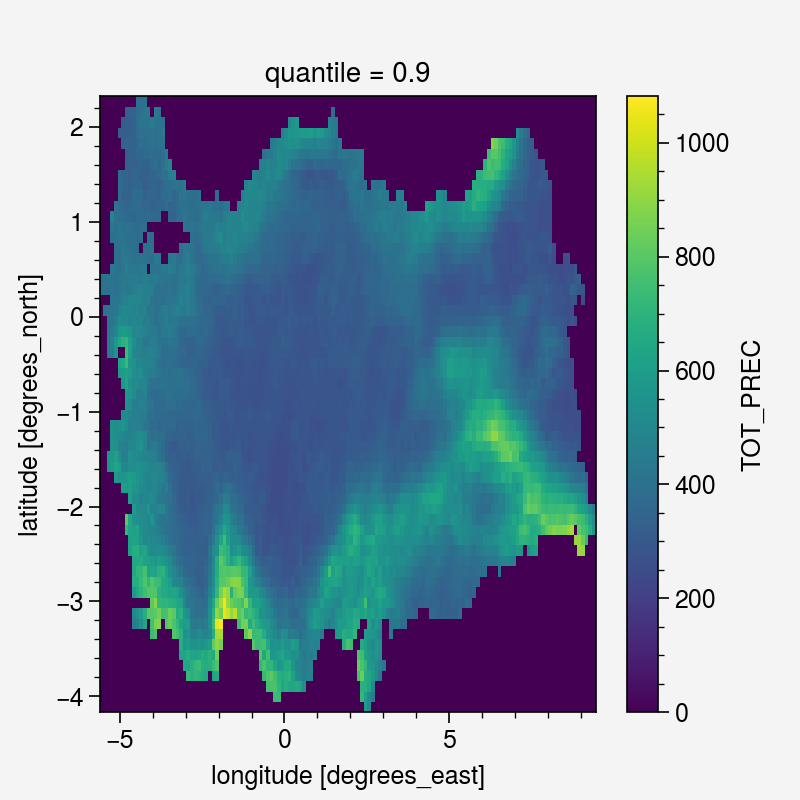

In [64]:
dt_model_qx.plot()

#### 1.3.2 ERA5

In [65]:
dt_era5_qx = dt_era5.groupby('time.year')\
                     .sum(dim='time')\
                     .quantile(q,
                               dim='year',
                                )

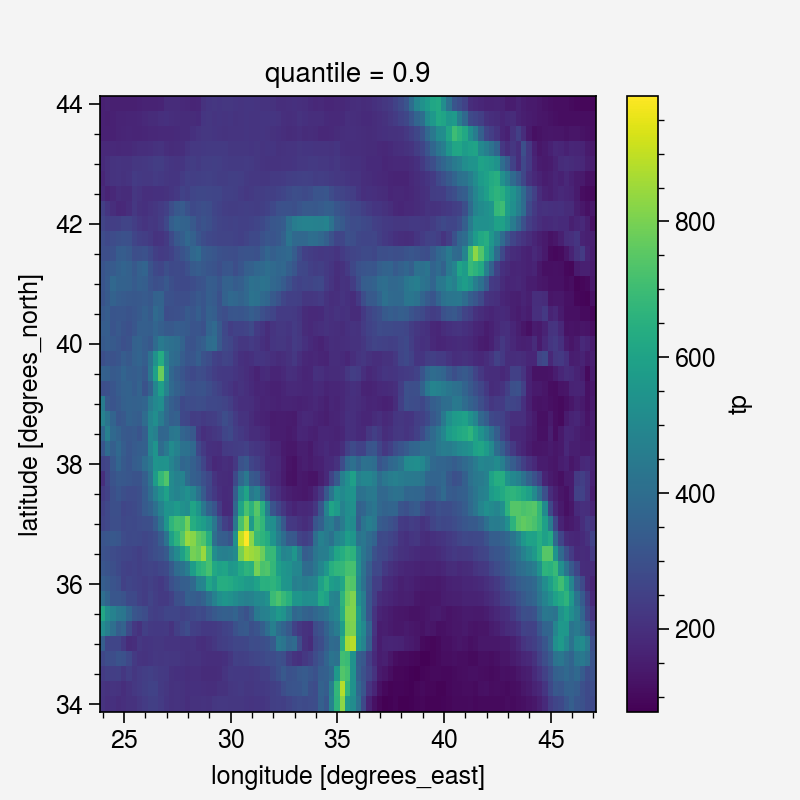

In [66]:
dt_era5_qx.plot()

### 1.4 Regrid

In [67]:
# regrid
dt_era5_qx_regrid = utils.regrid_match(utils.assign_proj_to_model(dt_model_qx), 
                                    utils.assign_proj_to_era5(dt_era5_qx, regrid=False)
                                   )

# discard nodata
dt_era5_qx_regrid = utils.discard_nodata_problem(dt_era5_qx_regrid)

# rename coord names
dt_era5_qx_regrid = dt_era5_qx_regrid.rename({'y':'rlat', 'x':'rlon'})

# exact match for coordinate values
dt_era5_qx_regrid['rlat'] = dt_model_qx['rlat']
dt_era5_qx_regrid['rlon'] = dt_model_qx['rlon']

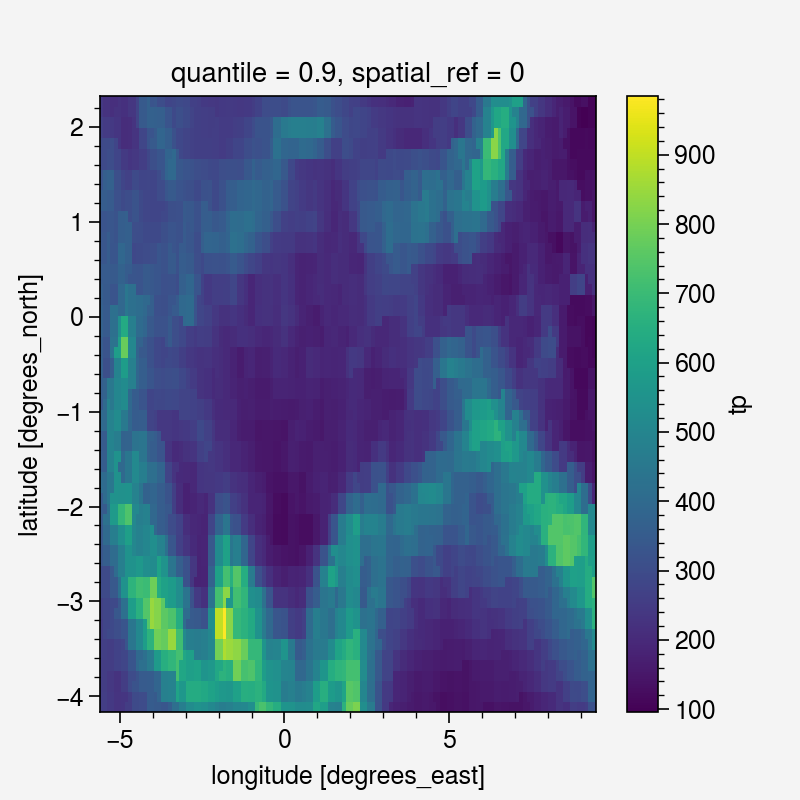

In [68]:
dt_era5_qx_regrid.plot()

### 1.5 Clip to Turkey

In [69]:
def clip_to_city(data, shapefile):
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [70]:
path_shape = fr'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_tr = gpd.read_file(path_shape)

#### 1.5.1 Model

In [71]:
dt_model_qx_clipped = clip_to_city(utils.assign_proj_to_model(dt_model_qx), shape_tr)

In [72]:
int(dt_model_qx_clipped.max().values)

1082

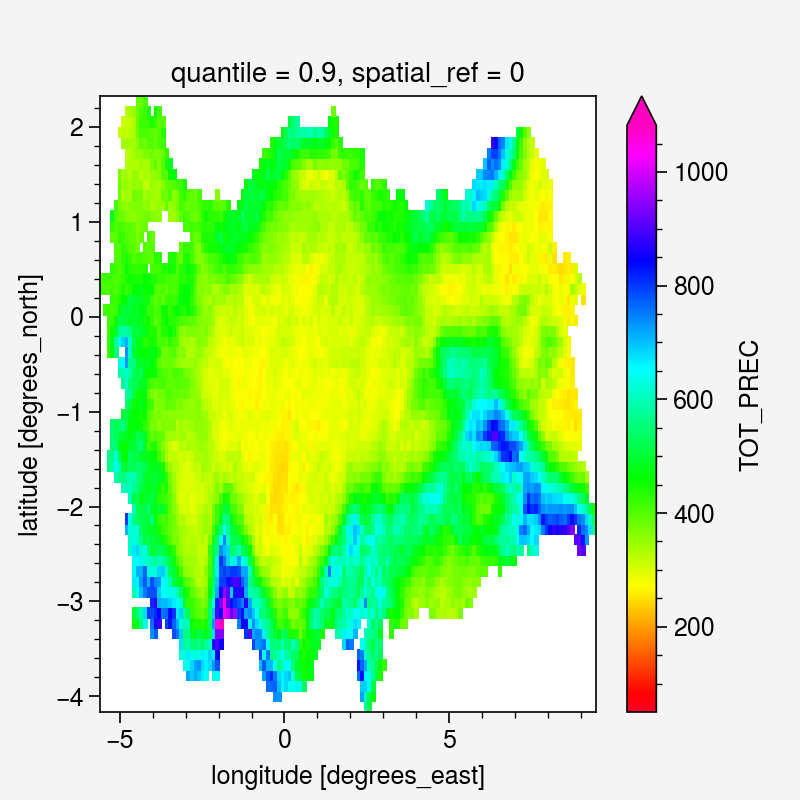

In [73]:
dt_model_qx_clipped.plot(cmap='gist_rainbow', vmin=50, vmax=int(dt_model_qx_clipped.max().values))

#### 1.5.2 ERA5

In [74]:
dt_era5_qx_clipped = clip_to_city(dt_era5_qx_regrid,
                                  shape_tr
                                 )
dt_era5_qx_clipped = utils.discard_nodata_problem(dt_era5_qx_clipped)

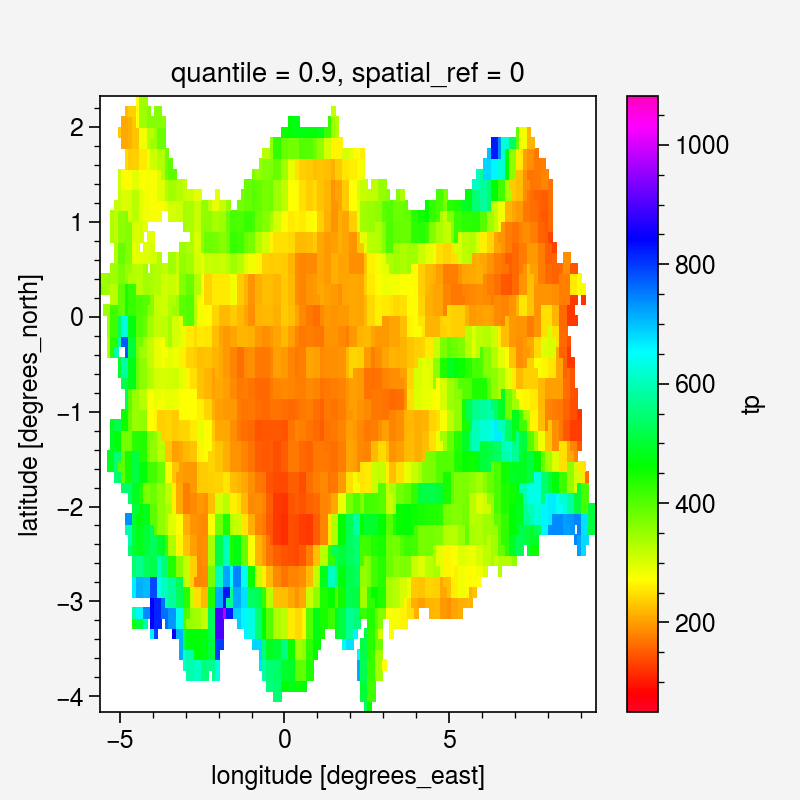

In [75]:
dt_era5_qx_clipped.plot(cmap='gist_rainbow', vmin=50, vmax=int(dt_model_qx_clipped.max().values))

#### 1.5.3 Difference

In [76]:
model_minus_era5 = dt_model_qx_clipped - dt_era5_qx_clipped 

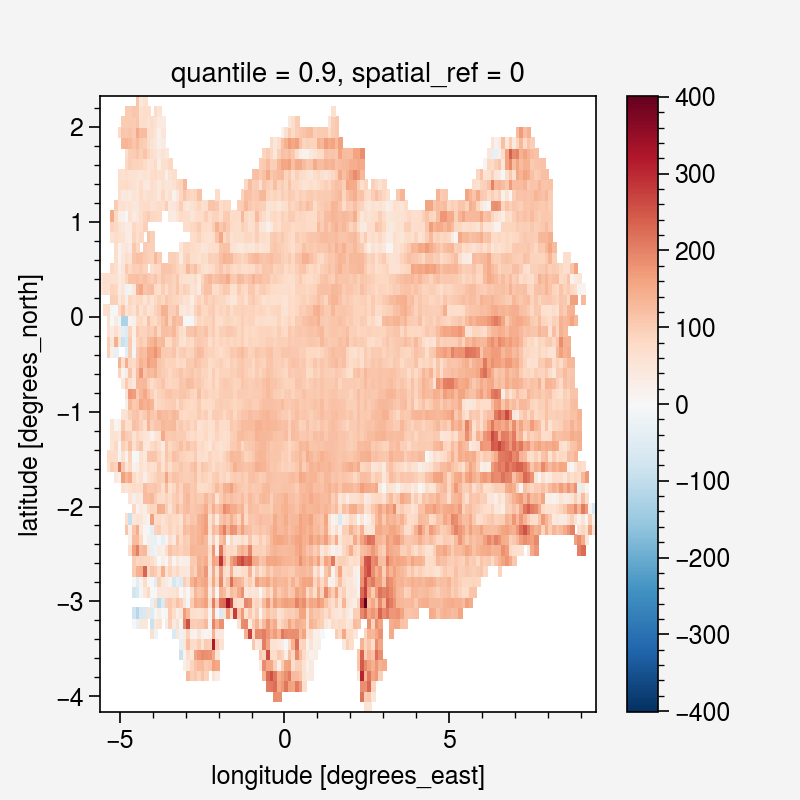

In [77]:
model_minus_era5.plot()

### 1.6 Visualize

#### 1.6.1 Options

In [78]:
max(int(dt_era5_qx_clipped.max().values), 
    int(dt_model_qx_clipped.max().values)
   )

1082

In [79]:
clevs_diff = np.arange(-2.5,
                       2.51,
                       0.25
                      )
#clevs_total = np.arange(50, 
#                        max(int(dt_era5_qx_clipped.max().values), 
#                            int(dt_model_qx_clipped.max().values)
#                           ),
#                        50)
clevs_total = np.arange(50, 1001, 50)

In [80]:
# Parameters to change (plot) -------------------
# projection
proj = dt_model.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = utils.get_proj_info_model()

# fig features
fig_array = [[1, 1],
             [2, 2],
             [3, 3]
            ]
graphic_no = 3

name_lat = 'rlat'
name_lon = 'rlon'

#cmap_base = proplot.Colormap('roma')
cmap_diff = proplot.Colormap('ColdHot')
norm_diff = BoundaryNorm(clevs_diff,
                    ncolors=cmap_diff.N, 
                    clip=True)

cmap_base_opt = [
    "#dff2f7",
    "#a9dff9",
    "#8acef5",
    "#67aae1", 
    "#4aa77a", 
    "#a2cf5a", 
    "#fed755", 
    "#f29a3e", 
    "#ef6934",
    "#cf212a",
    "#620878",
    "#c611f2",
    "#db7cf2"
    
]
cmap_base = ListedColormap(cmap_base_opt)
cmap_base_opt_extend = (cmap_base(np.linspace(0, 1, len(cmap_base_opt) * 3)) * 255).astype(np.uint8)
cmap_base_extend = LinearSegmentedColormap.from_list('', np.array(cmap_base_opt_extend) / 255, 256)
norm_base = BoundaryNorm(clevs_total,
                    ncolors=cmap_base_extend.N, 
                    clip=True)

#### 1.6.2 Plot

/tmp/ipykernel_1407/3906004622.py:3: ProplotWarning: Ignoring unused projection-specific format() keyword argument(s): {'aspect': 10}
  fig, axs = proplot.subplots(fig_array,
/tmp/ipykernel_1407/3906004622.py:55: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 50, 'vmax': 1400}
  mesh_cosmo = axs[0].pcolormesh(dt_model_qx_clipped[name_lon].values,
/tmp/ipykernel_1407/3906004622.py:66: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 50, 'vmax': 1400}
  mesh_era5 = axs[1].pcolormesh(dt_era5_qx_clipped[name_lon].values,
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  return func(self, *args, **kwargs)
/home/donmezk16/Downloads/anaconda3/envs/AFA

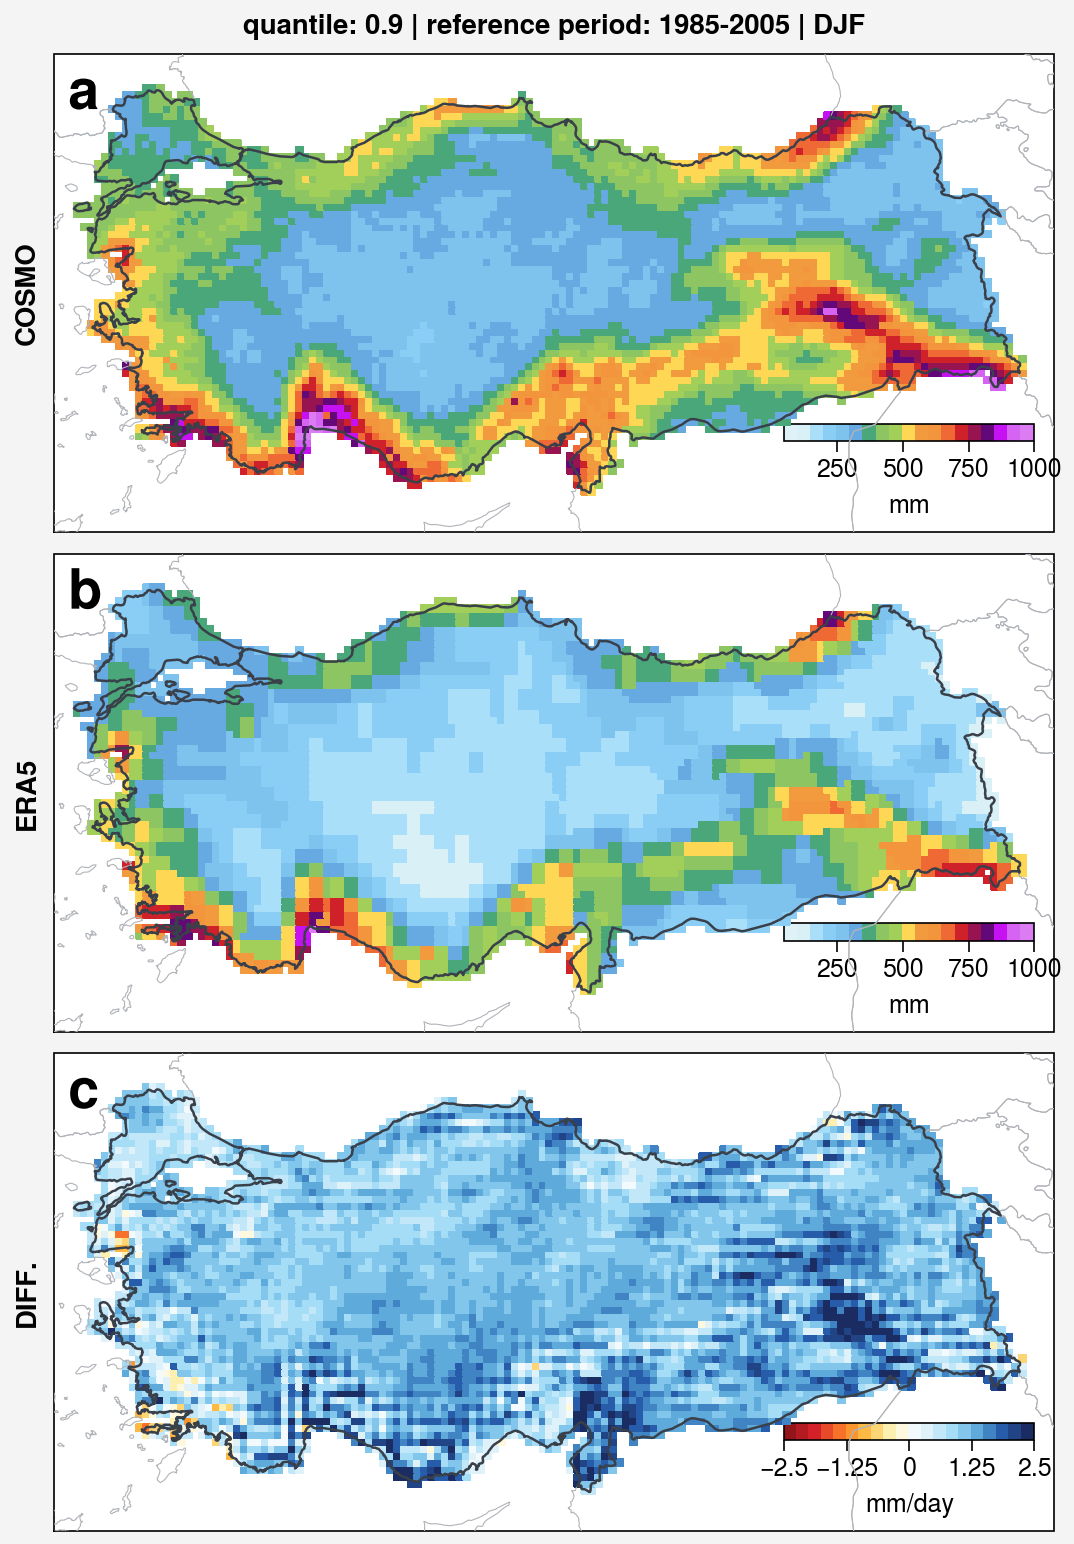

In [81]:
#%%capture
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=10,
                            axwidth=5,
                            proj=[lcc, lcc, lcc],
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.86,
                            wspace=0.56,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           #abcbbox = True,
           abc_kw={'size':20},
           abc=True,
           zorder=50)

# Turkey limits
axs.format(lonlim=(25.8, 45.1), 
           latlim=(35., 42.2), 
           longrid=False, 
           latgrid = False)

# shapefile
# External complementary shapefiles
shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
cts = ['Syria', 'Iraq', 'Iran',
       'Azerbaijan', 'Armenia',
       'Russia', 'Georgia', 'Bulgaria',
       'Greece', 'Cyprus', 'Northern Cyprus']
    
# add external shapefile geometries
for country in shpreader.Reader(shpfilename).records():
    
    if country.attributes['ADMIN'] in cts:
        
        count_shp = country.geometry
        for i in range(graphic_no):
            axs[i].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='none', edgecolor = '#b0b3b8',
                              linewidth = 0.4, zorder = 21,)
            
    elif country.attributes['ADMIN'] == 'Turkey':
        count_shp = country.geometry
        for i in range(graphic_no):
            axs[i].add_geometries([count_shp], cartopy.crs.PlateCarree(),
                              facecolor='none', edgecolor = '#3a404a',
                              linewidth = 0.9, zorder = 22,
                                 )
# for cosmo          
mesh_cosmo = axs[0].pcolormesh(dt_model_qx_clipped[name_lon].values,
                  dt_model_qx_clipped[name_lat].values,
                  dt_model_qx_clipped.values,
                  cmap=cmap_base_extend,
                  norm=norm_base,
                  vmin=50, 
                  vmax=1400,
                  transform=lcc,
                  zorder=20)

# for era5          
mesh_era5 = axs[1].pcolormesh(dt_era5_qx_clipped[name_lon].values,
                  dt_era5_qx_clipped[name_lat].values,
                  dt_era5_qx_clipped.values,
                  cmap=cmap_base_extend,
                  norm=norm_base,
                  vmin=50,
                  vmax=1400,
                  transform=lcc,
                  zorder=20)

# for difference          
mesh_diff = axs[2].pcolormesh(model_minus_era5[name_lon].values,
                  model_minus_era5[name_lat].values,
                  (model_minus_era5/90).values,
                  cmap=cmap_diff.reversed(),
                  norm=norm_diff,
                  transform=lcc,
                  zorder=20)

axs.format(rowlabels=['COSMO', 'ERA5', 'DIFF.'],
           collabels=[fr'quantile: {q} | reference period: 1985-2005 | {season}']
           #toplabels_kw = {'size':15},
          )

# colorbars
axs[0].colorbar(mesh_cosmo,
                 label='mm',
                 loc='lr', length=10,  # length is em widths
                 tickminor=False, alpha=0.5,
                 width=0.7,
                 labelsize = 9,
                 ticklabelsize = 9,
                 frame=False,
                 pad = 0.8
                )

axs[1].colorbar(mesh_era5,
                 label='mm',
                 loc='lr', length=10,  # length is em widths
                 tickminor=False, alpha=0.5,
                 width=0.7,
                 labelsize = 9,
                 ticklabelsize = 9,
                 frame=False,
                 pad = 0.8
                )

axs[2].colorbar(mesh_diff,
                 label='mm/day',
                 loc='lr', length=10,  # length is em widths
                 tickminor=False, alpha=0.5,
                 width=0.7,
                 labelsize = 9,
                 ticklabelsize = 9,
                 frame=False,
                 pad = 0.8,
                )

# save
#save figure
plt.savefig(fr'pictures/BC_{bias_algo}_verification_{season}_q{q}.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=300)

## 2. Miscallenous

In [110]:
year_choice = 2003
model = xr.open_dataset(fr'{path_general}/cosmo/yearly/BC/BC_{bias_algo}_Tr011_MPI_RF_PR_DJF_1hr_clipped_{year_choice}.nc')['TOT_PREC']
#model = xr.open_dataset(fr'{path_general}/cosmo/yearly/Tr011_MPI_RF_PR_DJF_1hr_{year_choice}.nc')['TOT_PREC']

In [111]:
era5 = xr.open_dataset(fr'{path_general}/era5/yearly/era5_TOT_PREC_DJF_1hr_{year_choice}.nc')['tp']*1e3

In [112]:
model = utils.assign_proj_to_model(model)
era5 = utils.assign_proj_to_era5(era5)

In [113]:
# regrid
era5_regrid = utils.regrid_match(utils.assign_proj_to_model(model), 
                                    utils.assign_proj_to_era5(era5, regrid=False)
                                   )

# discard nodata
era5_regrid = utils.discard_nodata_problem(era5_regrid)

# rename coord names
era5_regrid = era5_regrid.rename({'y':'rlat', 'x':'rlon'})

# exact match for coordinate values
era5_regrid['rlat'] = model['rlat']
era5_regrid['rlon'] = model['rlon']

era5_clipped = clip_to_city(era5_regrid,
                                  shape_tr
                                 )
era5_clipped = utils.discard_nodata_problem(era5_clipped)

model_clipped = clip_to_city(model,
                                  shape_tr
                                 )
model_clipped = utils.discard_nodata_problem(model_clipped)

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/rioxarray/raster_writer.py:108: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/rioxarray/raster_writer.py:108: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


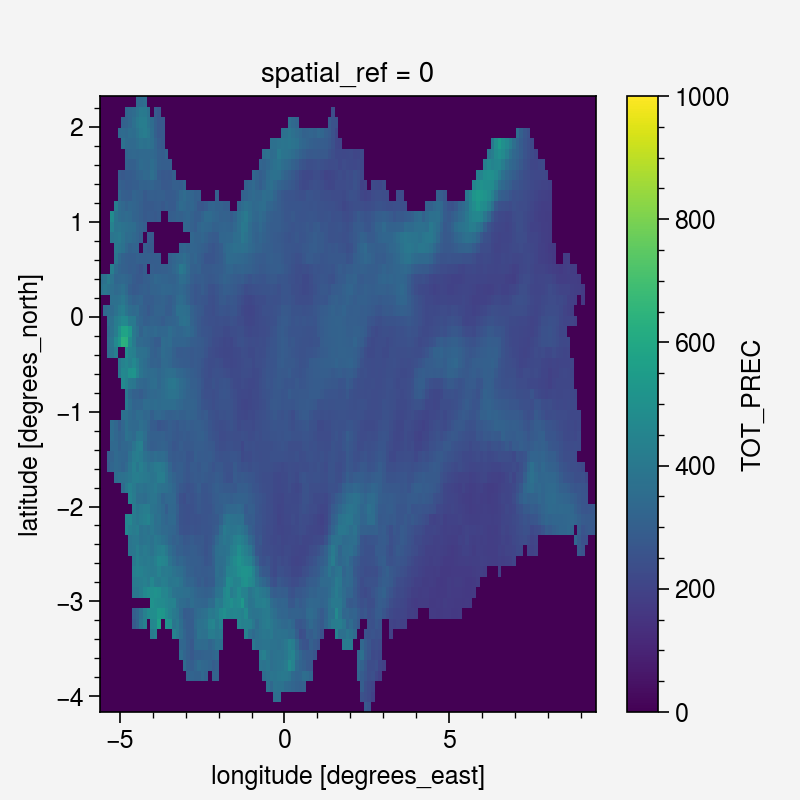

In [114]:
#  bc
model_clipped.sum(dim='time').plot(vmax=1000, vmin=0)

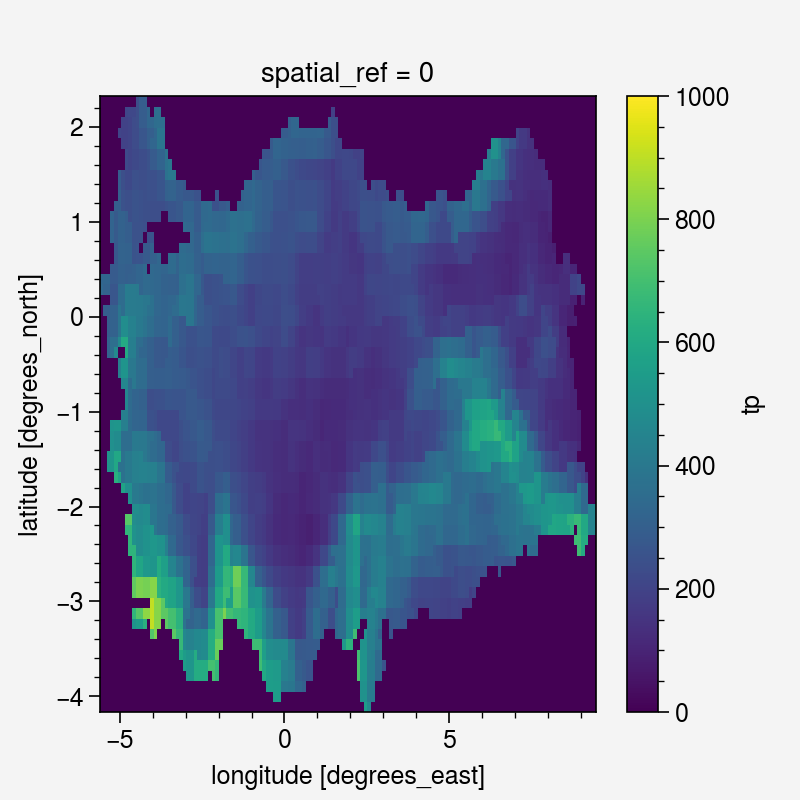

In [115]:
era5_clipped.sum(dim='time').plot(vmax=1000, vmin=0)

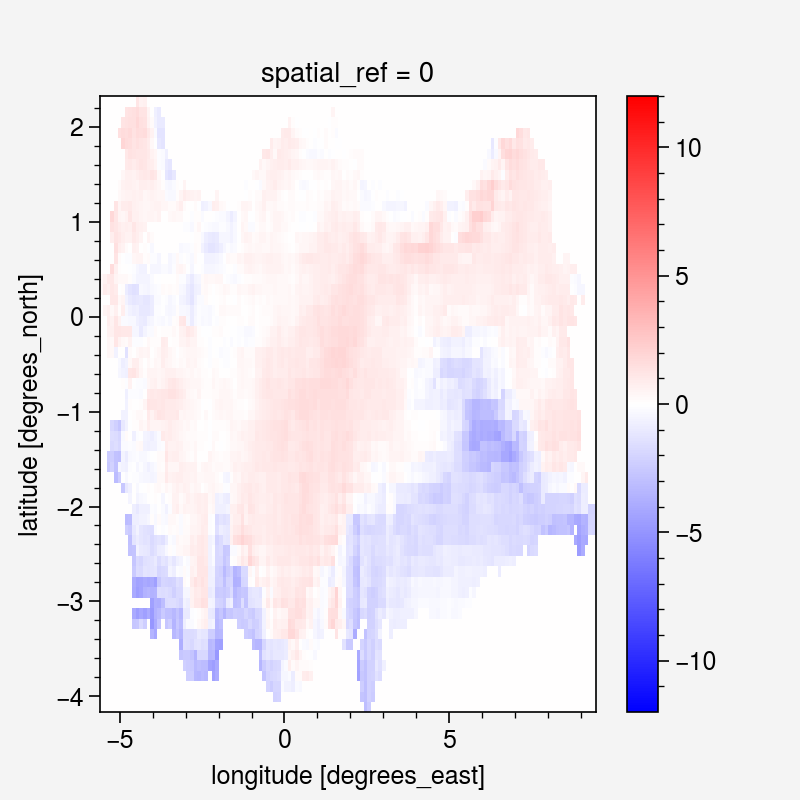

In [116]:
# with BC
((model.sum(dim='time') - era5_clipped.sum(dim='time'))/90).plot(vmax=12, vmin=-12, cmap='bwr')

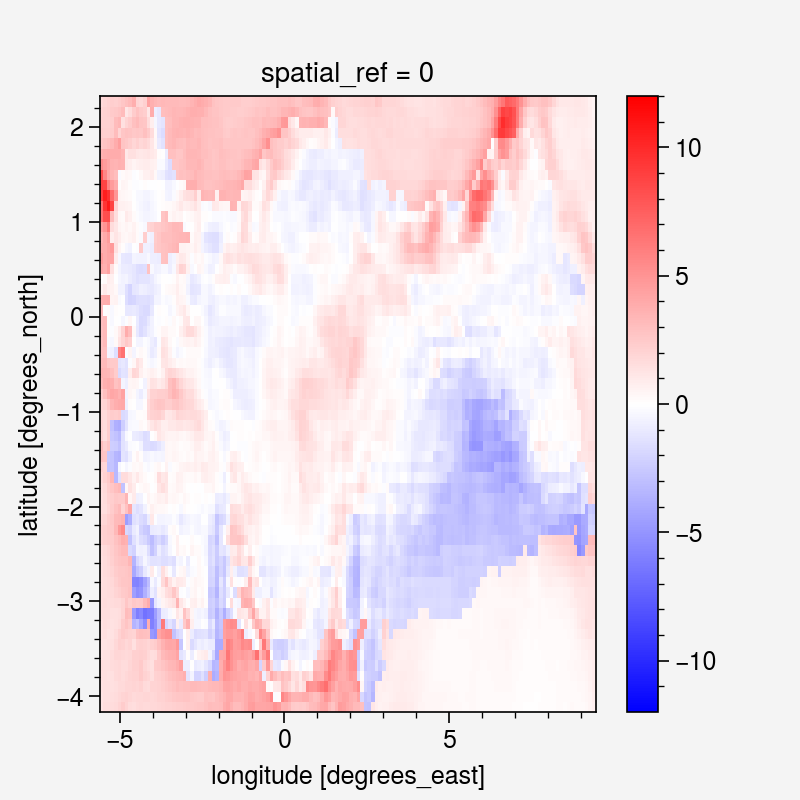

In [109]:
# with no BC
((model.sum(dim='time') - era5_clipped.sum(dim='time'))/90).plot(vmax=12, vmin=-12, cmap='bwr')